In [1]:
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cftime

import xarray
import dask

In [2]:
dask.config.set(scheduler="processes")

# IA monthly and ESGF-VA

In [3]:
url = "https://github.com/SantanderMetGroup/ATLAS/raw/refs/heads/main/warming-levels/CMIP6_Atlas_WarmingLevels.csv"
gwls_file = url.split("/")[-1]
with open(gwls_file, "w") as f:
    response = requests.get(url)
    response.raise_for_status()
    f.write(response.text)
gwls = pd.read_csv(gwls_file)
model_runs = gwls["model_run"].str.split("_", expand=True).set_index(0)[1].to_dict()

In [4]:
esgf_va_catalog = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip").fillna("")
atlas_ipcc_catalog = pd.read_csv("atlas.csv")

/tmp/ipykernel_347734/4281229923.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  esgf_va_catalog = pd.read_csv("https://hub.climate4r.ifca.es/thredds/fileServer/public/inventory.csv.zip").fillna("")


Version was extracted from https://raw.githack.com/IPCC-WG1/Atlas/devel/data-sources/CMIP6/CMIP6.html.

In [5]:
def find_model_runs(esgf_va_catalog, atlas_ipcc_catalog, model_runs, experiment):
    ignored_models = [
        "EC-Earth3-Veg", # replica unavailable
        "BCC-CSM2-MR", # time units change across netCDF files
        "KACE-1-0-G", # there is no ssp585 for this model
        "UKESM1-0-LL", # there is no ssp585 for this model
        "MIROC-ES2L", # no replica seems to work
    ]
    
    preferred_replicas = {
        "historical": {
            "EC-Earth3-Veg": "esgf3.dkrz.de",
            "HadGEM3-GC31-LL": "", # esgf-data04.diasjp.net netcdf-java error, ...
        },
        "ssp585": {
            "EC-Earth3-Veg": "esgf3.dkrz.de",
            "HadGEM3-GC31-LL": "esgf-data1.llnl.gov",
        },
    }
    
    esgf_va_model_runs = []
    for model in model_runs:
        if model in ignored_models:
            continue
    
        esgf_va_subset = esgf_va_catalog.query(f"project == 'CMIP6' & model == '{model}' & table == 'day' & variable == 'pr' & experiment == '{experiment}'").set_index(["project", "model", "experiment", "version"]).drop(["variable"], axis=1)
        atlas_ipcc_subset = atlas_ipcc_catalog.drop(["variable"], axis=1)
        
        subset = esgf_va_subset.join(atlas_ipcc_subset.set_index(["project", "model", "experiment", "version"]), on=["project", "model", "experiment", "version"], how="inner")
        if len(subset) > 0:
            # Choose the preferred replica or default to esgf.ceda.ac.uk
            if model in preferred_replicas[experiment]:
                replica = preferred_replicas[experiment][model]
            else:
                replica = "esgf.ceda.ac.uk"
    
            # Probe if the required model member is included in the esgf-va
            url = subset[subset["replica"] == replica]["location"].iloc[0]
            print(url)
            ds = xarray.open_dataset(
                url,
                decode_times=False,
                drop_variables=["tracking_id", "further_info_url", "time_bnds", "lat_bnds", "lon_bnds"])
    
            if model_runs[model].encode("ascii") in ds["variant_label"].values:
                record = {"url": url, "model_run": model + "_" + model_runs[model]}
                esgf_va_model_runs.append(record)

    return pd.DataFrame.from_records(esgf_va_model_runs)

In [6]:
ssp585_model_runs = find_model_runs(esgf_va_catalog, atlas_ipcc_catalog, model_runs, "ssp585")
historical_model_runs = find_model_runs(esgf_va_catalog, atlas_ipcc_catalog, model_runs, "historical")

https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp585_day_gn_v20191108/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp585_day_pr_gn_v20191108.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CSIRO_ACCESS-ESM1-5_ssp585_day_gn_v20191115/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CSIRO_ACCESS-ESM1-5_ssp585_day_pr_gn_v20191115.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_AWI_AWI-CM-1-1-MR_ssp585_day_gn_v20190529/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_AWI_AWI-CM-1-1-MR_ssp585_day_pr_gn_v20190529.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CAMS_CAMS-CSM1-0_ssp585_day_gn_v20191106/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CAMS_CAMS-CSM1-0_ssp585_day_pr_gn_v20191106.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/Scena

/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CMCC_CMCC-CM2-SR5_ssp585_day_gn_v20200622/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CMCC_CMCC-CM2-SR5_ssp585_day_pr_gn_v20200622.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp585_day_gr_v20190219/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1_ssp585_day_pr_gr_v20190219.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1-HR_ssp585_day_gr_v20191202/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-CM6-1-HR_ssp585_day_pr_gr_v20191202.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-ESM2-1_ssp585_day_gr_v20191021/replicas/esgf.ceda.ac.uk/CMIP6_ScenarioMIP_CNRM-CERFACS_CNRM-ESM2-1_ssp585_day_pr_gr_v20191021.ncml
https://hub.ipcc.ifca.es/thredds/dod

/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CMCC_CMCC-CM2-SR5_historical_day_gn_v20200616/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CMCC_CMCC-CM2-SR5_historical_day_pr_gn_v20200616.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1_historical_day_gr_v20180917/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1_historical_day_pr_gr_v20180917.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1-HR_historical_day_gr_v20191021/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CNRM-CERFACS_CNRM-CM6-1-HR_historical_day_pr_gr_v20191021.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_CNRM-CERFACS_CNRM-ESM2-1_historical_day_gr_v20181206/replicas/esgf.ceda.ac.uk/CMIP6_CMIP_CNRM-CERFACS_CNRM-ESM2-1_historical_day_pr_gr_v20181206.ncml
https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/CMIP/day/CMIP6_CMIP_EC-Eart

Ahora ya tenemos las URL en común.

In [7]:
df = historical_model_runs.set_index("model_run").join(ssp585_model_runs.set_index("model_run"), how="inner", lsuffix="h", rsuffix="s").rename({"urlh": "historical", "urls": "ssp585"}, axis=1)

In [8]:
df

historical  \
model_run                                                                     
ACCESS-CM2_r1i1p1f1       https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
ACCESS-ESM1-5_r1i1p1f1    https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
CAMS-CSM1-0_r2i1p1f1      https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
CanESM5_r1i1p1f1          https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
CESM2-WACCM_r1i1p1f1      https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
CMCC-CM2-SR5_r1i1p1f1     https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
CNRM-CM6-1_r1i1p1f2       https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
CNRM-CM6-1-HR_r1i1p1f2    https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
CNRM-ESM2-1_r1i1p1f2      https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
EC-Earth3_r1i1p1f1        https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
FGOALS-g3_r1i1p1f1        https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
HadGEM3-GC31-LL_r1i1p1f3  https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
IITM-ESM_r1i1p1f1         https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
IPSL-CM6A-LR_r1i1p1f1     https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
MPI-ESM1-2-HR_r1i1p1f1    https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
NorESM2-LM_r1i1p1f1       https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   
TaiESM1_r1i1p1f1          https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...   

                                                                     ssp585  
model_run                                                                    
ACCESS-CM2_r1i1p1f1       https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
ACCESS-ESM1-5_r1i1p1f1    https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
CAMS-CSM1-0_r2i1p1f1      https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
CanESM5_r1i1p1f1          https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
CESM2-WACCM_r1i1p1f1      https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
CMCC-CM2-SR5_r1i1p1f1     https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
CNRM-CM6-1_r1i1p1f2       https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
CNRM-CM6-1-HR_r1i1p1f2    https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
CNRM-ESM2-1_r1i1p1f2      https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
EC-Earth3_r1i1p1f1        https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
FGOALS-g3_r1i1p1f1        https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
HadGEM3-GC31-LL_r1i1p1f3  https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
IITM-ESM_r1i1p1f1         https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
IPSL-CM6A-LR_r1i1p1f1     https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
MPI-ESM1-2-HR_r1i1p1f1    https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
NorESM2-LM_r1i1p1f1       https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...  
TaiESM1_r1i1p1f1          https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/...

In [9]:
def load_datasets(locations, members, experiment):
    dss = []
    for location in locations:
        name = location.split("/")[-1]
        model = name.split("_")[3]

        ds = xarray.open_dataset(
            location,
            drop_variables=["tracking_id", "further_info_url", "time_bnds", "lat_bnds", "lon_bnds"]).sel(
            variant_label=members[model].encode("ascii"))

        if experiment == "ssp585":
            ds = ds.isel(time=slice(None, 31390))
            # limit to 2100, avoid cf time indexing issues
            if isinstance(ds["time"][0].item(), cftime.Datetime360Day):
                ds = ds.sel(time=slice("20150101", "21001230"))
            else:
                ds = ds.sel(time=slice("20150101", "21001231"))
        elif experiment == "historical":
            pass
        else:
            raise ValueError("Invalid experiment... exiting")
    
        # add the model_run global attribute
        ds.attrs["model_run"] = f"{model}_{members[model]}"
        dss.append(ds)

    return dss

In [10]:
historical_dss = load_datasets(df["historical"], model_runs, "historical")
ssp585_dss = load_datasets(df["ssp585"], model_runs, "ssp585")

/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/tmp/ipykernel_347734/3240490667.py:7: SerializationWarning: Unable to decode time axis into full numpy.datetime64[ns] objects, continuing using cftime.datetime objects instead, reason: dates out of range. To silence this warning use a coarser resolution 'time_unit' or specify 'use_cftime=True'.
  ds = xarray.open_dataset(
/home/jovyan/nc48/lib/python3.11/site-packages/xarray/conventions.py:200: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


Print size of the datasets:

In [11]:
for ds in historical_dss:
    print(f'{ds["pr"].size * ds["pr"].dtype.itemsize / 2**20:.2f} MB')

6356.07 MB
6400.21 MB
11770.51 MB
1882.03 MB
12703.92 MB
12703.71 MB
7533.12 MB
59588.20 MB
7533.12 MB
30132.50 MB
3348.36 MB
6264.84 MB
4149.17 MB
4733.95 MB
16949.53 MB
3175.93 MB
12703.71 MB


In [12]:
for ds in ssp585_dss:
    print(f'{ds["pr"].size * ds["pr"].dtype.itemsize / 2**20:.2f} MB')

3310.66 MB
3333.65 MB
6063.67 MB
980.94 MB
6621.33 MB
6621.33 MB
3923.75 MB
31037.48 MB
3923.75 MB
15695.00 MB
1724.30 MB
3265.31 MB
2137.44 MB
2465.76 MB
8828.44 MB
1655.33 MB
6621.33 MB


Heavy computation (lo interesante sería hacer esto con Pangeo tambn).

Need to be careful how to retrieve the Europe subset based on `(0, 360)`.

In [13]:
def efficient_retrieval_and_compute(ds):
    lats, lons = slice(35, 72), slice(-11, 35) # Europe in (-180, 180)

    # handle Europe being split when using (0, 360)
    if ds["lon"].min().item() >= 0:
        left = ds.sel(lon=slice(0, 36), lat=lats).chunk({"time": 1000})
        right = ds.sel(lon=slice(348, 360), lat=lats).chunk({"time": 1000})

        spatial = xarray.concat([left, right], dim="lon")
    else:
        spatial = ds.sel(lon=lons, lat=lats)

    winter = spatial.sel(time=spatial.time.dt.month.isin([12,1,2])).resample({"time": "MS"}).sum().load()
    winter = winter.assign_coords(lon=((winter["lon"] + 180) % 360) - 180).sortby("lon")

    return winter

In [14]:
%%time

historical_dss_subset = [efficient_retrieval_and_compute(ds) for ds in historical_dss]

CPU times: user 5min 42s, sys: 1min 18s, total: 7min
Wall time: 14min 49s


In [15]:
%%time

ssp585_dss_subset = [efficient_retrieval_and_compute(ds) for ds in ssp585_dss]

CPU times: user 2min 57s, sys: 38.3 s, total: 3min 36s
Wall time: 9min 51s


In [16]:
for ds in historical_dss_subset:
    print(f'{ds["pr"].size * ds["pr"].dtype.itemsize / 2**20:.2f} MB')

5.66 MB
5.89 MB
10.72 MB
1.67 MB
11.20 MB
11.19 MB
6.68 MB
54.22 MB
6.68 MB
27.62 MB
3.44 MB
5.66 MB
3.93 MB
4.16 MB
15.41 MB
2.87 MB
11.19 MB


In [17]:
for ds in ssp585_dss_subset:
    print(f'{ds["pr"].size * ds["pr"].dtype.itemsize / 2**20:.2f} MB')

2.95 MB
3.07 MB
5.52 MB
0.87 MB
5.83 MB
5.83 MB
3.48 MB
28.26 MB
3.48 MB
14.40 MB
1.77 MB
2.95 MB
2.02 MB
2.17 MB
8.03 MB
1.50 MB
5.83 MB


# pr < 0?

In [80]:
for ds in ssp585_dss_subset:
    print(ds["pr"].min().item())

1.4578049558622297e-06
1.1000258837157162e-06
4.253403737906051e-17
1.6580185047132545e-07
1.1390235243879943e-07
6.427961807276006e-08
1.7224790482828212e-08
7.125119161344173e-09
1.930965964902498e-08
-1.1246235750950048e-24
3.1229349133354845e-06
2.396865284026717e-07
1.2379557448594092e-11
0.0
1.3925233233389273e-17
2.534541181375971e-07
1.3040565249866631e-07


In [81]:
for ds in ssp585_dss_subset_interp:
    print(ds["pr"].min().item())

-0.00022033327263973963
1.4698489242922127e-06
3.8770082041461375e-07
-0.0012853876416992795
1.602485798141768e-07
2.732311575136424e-07
-0.0001555116989233263
5.311835821429327e-08
-7.523296085044523e-05
-1.1246235750950048e-24
7.72937751207815e-06
-0.0002490394485357683
5.361958729362172e-07
-0.0006219811077023962
2.442192030580237e-08
1.771461730489451e-06
1.4680831025910112e-07


In [87]:
xarray.where(ssp585_dss_subset_interp[0]["pr"] < 0, 0, ssp585_dss_subset_interp[0]["pr"])

<xarray.DataArray 'pr' (time: 1032, lat: 37, lon: 46)> Size: 14MB
array([[[1.02271051e-03, 7.74095147e-04, 5.25479788e-04, ...,
         2.29373662e-03, 2.34799439e-03, 2.32734511e-03],
        [1.01457735e-03, 8.41320214e-04, 6.68063081e-04, ...,
         1.62762165e-03, 1.69327092e-03, 1.90905733e-03],
        [9.45026099e-04, 1.08786421e-03, 1.23070231e-03, ...,
         1.09122032e-03, 1.13545106e-03, 1.30985682e-03],
        ...,
        [8.49948844e-04, 8.16028601e-04, 7.82108358e-04, ...,
         1.07799175e-03, 1.04745817e-03, 1.04273277e-03],
        [8.93961263e-04, 9.95527966e-04, 1.09709467e-03, ...,
         9.10051150e-04, 8.79013986e-04, 7.80670131e-04],
        [8.91107449e-04, 9.27911113e-04, 9.64714777e-04, ...,
         9.78284426e-04, 9.53263726e-04, 8.70061891e-04]],

       [[5.01855288e-04, 3.84964681e-04, 2.68074075e-04, ...,
         2.14911497e-03, 2.39318847e-03, 2.63519181e-03],
        [3.66068829e-04, 2.84394633e-04, 2.02720438e-04, ...,
         1.41356136e-03, 1.48353885e-03, 1.78584792e-03],
        [2.92061015e-04, 2.16353248e-04, 1.40645481e-04, ...,
         9.06703290e-04, 9.13278350e-04, 1.13054000e-03],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[6.22737510e-04, 4.61247122e-04, 2.99756734e-04, ...,
         3.67021286e-05, 2.13310052e-04, 4.83508350e-04],
        [5.83815490e-04, 4.35379513e-04, 2.86943536e-04, ...,
         8.27076850e-05, 7.90345244e-05, 1.52851262e-04],
        [5.70343039e-04, 4.11109603e-04, 2.51876167e-04, ...,
         1.09560904e-04, 6.29767378e-05, 5.03376845e-05],
        ...,
        [3.86769170e-04, 3.49913463e-04, 3.13057757e-04, ...,
         1.88783076e-04, 2.57299319e-04, 3.46812396e-04],
        [3.45330060e-04, 3.29600500e-04, 3.13870940e-04, ...,
         3.82764008e-04, 4.06952011e-04, 4.25423877e-04],
        [3.04990246e-04, 2.98307701e-04, 2.91625156e-04, ...,
         2.42380317e-04, 2.50666641e-04, 2.60876172e-04]]])
Coordinates:
  * time           (time) datetime64[ns] 8kB 2015-01-01 ... 2100-12-01
    variant_label  |S64 64B b'r1i1p1f1'
  * lat            (lat) float64 296B 35.5 36.5 37.5 38.5 ... 69.5 70.5 71.5
  * lon            (lon) float64 368B -10.5 -9.5 -8.5 -7.5 ... 32.5 33.5 34.5

# To concat we need first to interpolate.

In [106]:
iad_catalog = pd.read_csv("https://raw.githubusercontent.com/SantanderMetGroup/IPCC-Atlas-Datalab/refs/heads/main/data_inventory.csv")
iad_subset = iad_catalog.query('type == "opendap" & variable == "pr" & project == "CMIP6" & experiment == "ssp585" & frequency == "mon"')
iad_location = iad_subset["location"].iloc[0]
iad_location

'https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CMIP6/ssp585/pr_CMIP6_ssp585_mon_201501-210012.nc'

In [107]:
iad = xarray.open_dataset(iad_location).sel(lat=slice(35, 72), lon=slice(-11, 35))
iad["member"] = [b"_".join(member.split(b"_")[1:]).decode("ascii") for member in iad["member"].values]
iad["pr"]

<xarray.DataArray 'pr' (member: 33, time: 1032, lat: 37, lon: 46)> Size: 232MB
[57963312 values with dtype=float32]
Coordinates:
  * member   (member) <U24 3kB 'ACCESS-CM2_r1i1p1f1' ... 'UKESM1-0-LL_r1i1p1f2'
  * time     (time) datetime64[ns] 8kB 2015-01-01 2015-02-01 ... 2100-12-01
  * lat      (lat) float64 296B 35.5 36.5 37.5 38.5 39.5 ... 68.5 69.5 70.5 71.5
  * lon      (lon) float64 368B -10.5 -9.5 -8.5 -7.5 ... 31.5 32.5 33.5 34.5
Attributes:
    standard_name:  lwe_thickness_of_precipitation_amount
    units:          mm
    cell_methods:   time: sum within days time: mean over days area: mean
    long_name:      Monthly mean of daily accumulated precipitation
    comment:        Monthly mean of daily accumulated precipitation of liquid...
    grid_mapping:   crs
    _ChunkSizes:    [  1   1 180 360]

In [122]:
ssp585_dss_subset_interp = [ds.interp(
    lat=iad["lat"],
    lon=iad["lon"],
    method="linear",
    kwargs={"fill_value": "extrapolate"})
              for ds in ssp585_dss_subset]

historical_dss_subset_interp = [ds.interp(
    lat=iad["lat"],
    lon=iad["lon"],
    method="linear",
    kwargs={"fill_value": "extrapolate"})
              for ds in historical_dss_subset]

In [123]:
for ds in ssp585_dss_subset_interp:
    ds["time"] = ds["time"].astype("datetime64[ns]")
    ds["pr"] = xarray.where(ds["pr"] < 0, 0, ds["pr"])

for ds in historical_dss_subset_interp:
    ds["time"] = ds["time"].astype("datetime64[ns]")
    ds["pr"] = xarray.where(ds["pr"] < 0, 0, ds["pr"])

In [124]:
cmip6_ssp585 = xarray.concat(
    ssp585_dss_subset_interp,
    xarray.Variable("member", [ds.attrs["model_run"] for ds in ssp585_dss_subset_interp]))

cmip6_historical = xarray.concat(
    historical_dss_subset_interp,
    xarray.Variable("member", [ds.attrs["model_run"] for ds in historical_dss_subset_interp]))

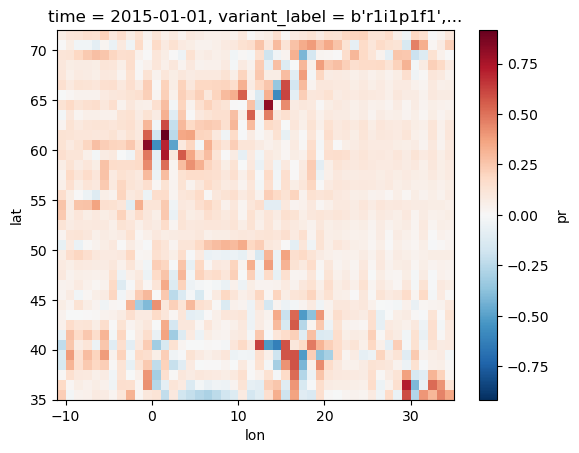

In [125]:
(
    cmip6_ssp585["pr"].sel(member="ACCESS-CM2_r1i1p1f1").isel(time=0) * 2880 -
    iad["pr"].sel(member="ACCESS-CM2_r1i1p1f1").isel(time=0)
).plot()

# Playing

Acumulado mensual entre esgf e iad? Lo q pasa es el de esgf en cell_methods tiene `time: mean` y el iad es sum within days.

In [126]:
86400 / 30

2880.0

# Ya por fin se puede reproducir el otro notebook

In [127]:
gwls3 = gwls[["model_run", "3_ssp585"]]
model_run_gwl = df.join(gwls3.set_index("model_run"), on="model_run")["3_ssp585"]
model_run_gwl

model_run
ACCESS-CM2_r1i1p1f1         2055
ACCESS-ESM1-5_r1i1p1f1      2060
CAMS-CSM1-0_r2i1p1f1        2088
CanESM5_r1i1p1f1            2040
CESM2-WACCM_r1i1p1f1        2053
CMCC-CM2-SR5_r1i1p1f1       2052
CNRM-CM6-1_r1i1p1f2         2058
CNRM-CM6-1-HR_r1i1p1f2      2051
CNRM-ESM2-1_r1i1p1f2        2064
EC-Earth3_r1i1p1f1          2057
FGOALS-g3_r1i1p1f1          2072
HadGEM3-GC31-LL_r1i1p1f3    2047
IITM-ESM_r1i1p1f1           2075
IPSL-CM6A-LR_r1i1p1f1       2050
MPI-ESM1-2-HR_r1i1p1f1      2073
NorESM2-LM_r1i1p1f1         2077
TaiESM1_r1i1p1f1            2052
Name: 3_ssp585, dtype: int64

In [128]:
cmip6_ssp585_gwl = xarray.concat(
    [cmip6_ssp585.sel(
        member=model_run,
        time=slice(f"{year-10}1201", f"{year+10}0201"))
     for model_run, year in model_run_gwl.reset_index().values
     if year != 9999],
    "member") * 2880

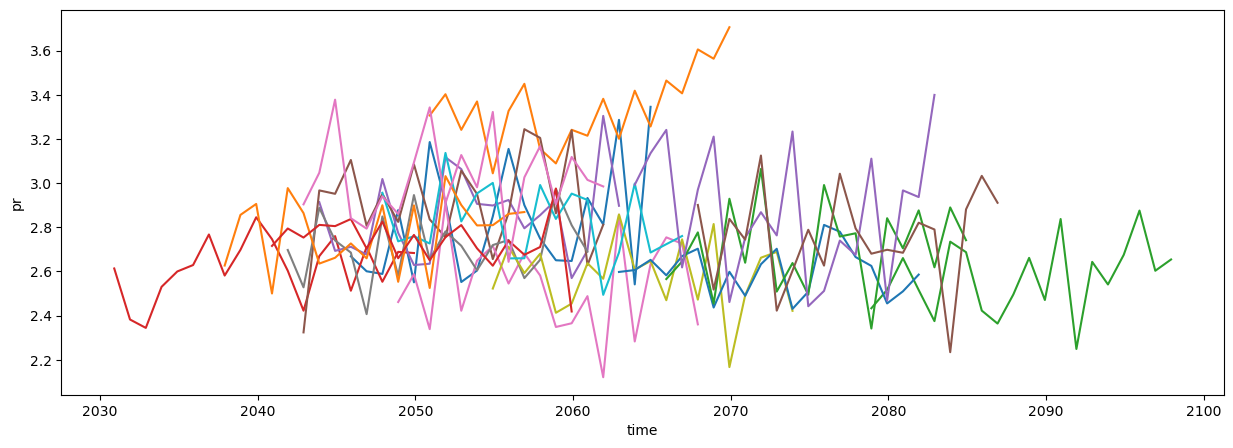

In [129]:
qmean = cmip6_ssp585_gwl.mean(["lat", "lon"]).resample(time="QS-DEC").mean()
plot = qmean["pr"].sel(time=qmean["pr"].time.dt.month==12).plot.line(x="time", add_legend=False, figsize=(15, 5))

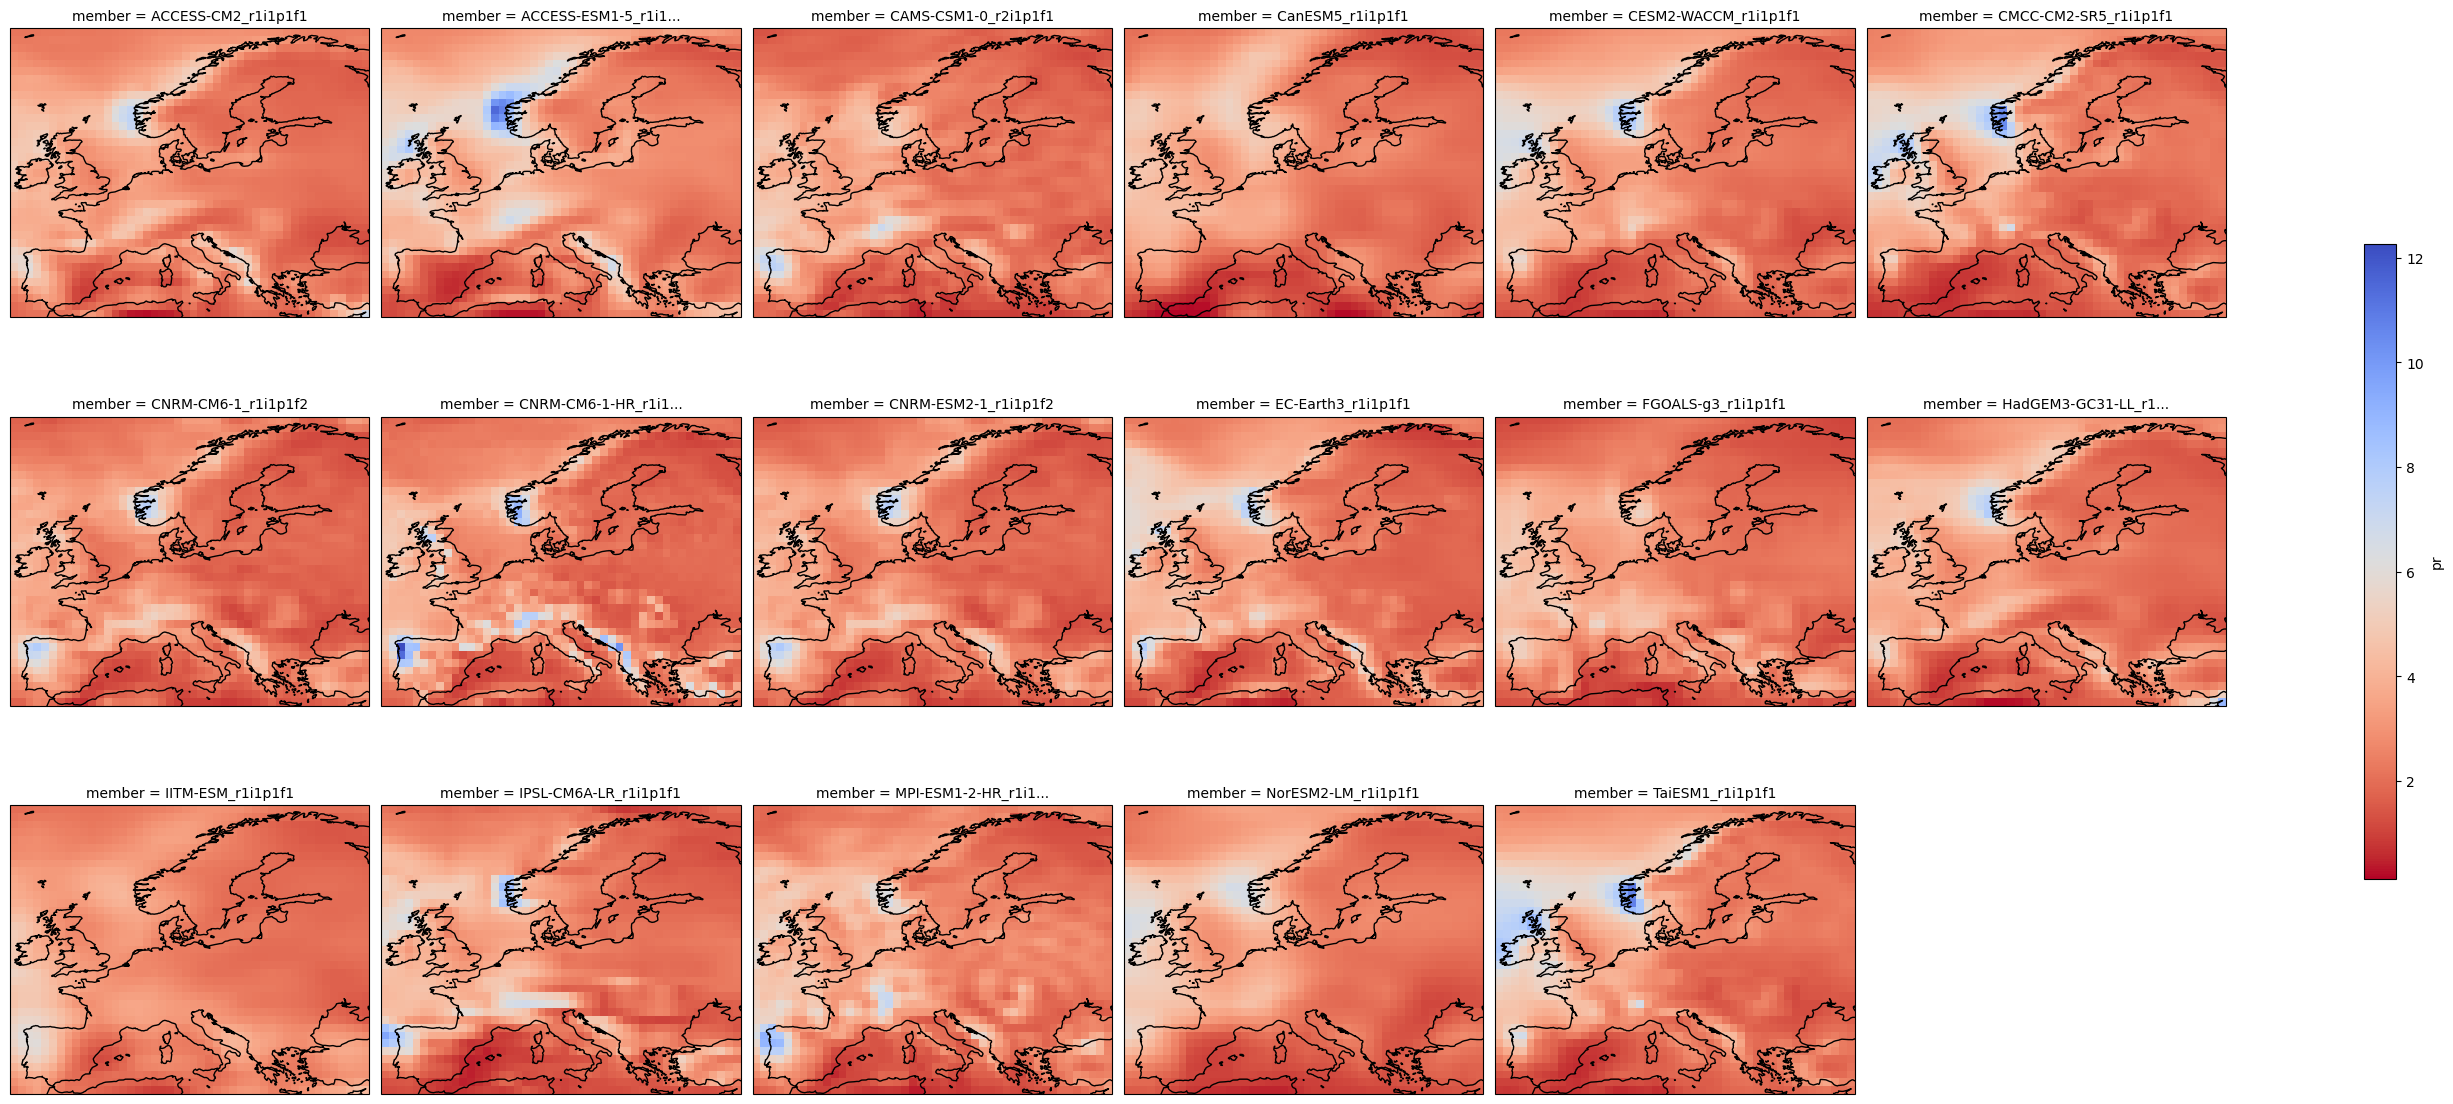

In [130]:
lats, lons = slice(35, 72), slice(-11, 35)

plot = cmip6_ssp585_gwl["pr"].mean("time").plot(
    x="lon", y="lat", col="member", col_wrap=6,
    # vmin=0, vmax=13,
    figsize=(28,13),
    add_colorbar=True,
    cmap="coolwarm_r",
    cbar_kwargs={"shrink": .5},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((lons.start, lons.stop, lats.start, lats.stop), ccrs.PlateCarree())

In [131]:
cmip6_historical_gwl = xarray.concat(
    [cmip6_historical.sel(
        member=model_run,
        time=slice("18501201", "19000201"))
     for model_run, year in model_run_gwl.reset_index().values
     if year != 9999],
    "member") * 2880

In [132]:
delta = cmip6_ssp585_gwl["pr"].mean("time") - cmip6_historical_gwl["pr"].mean("time")

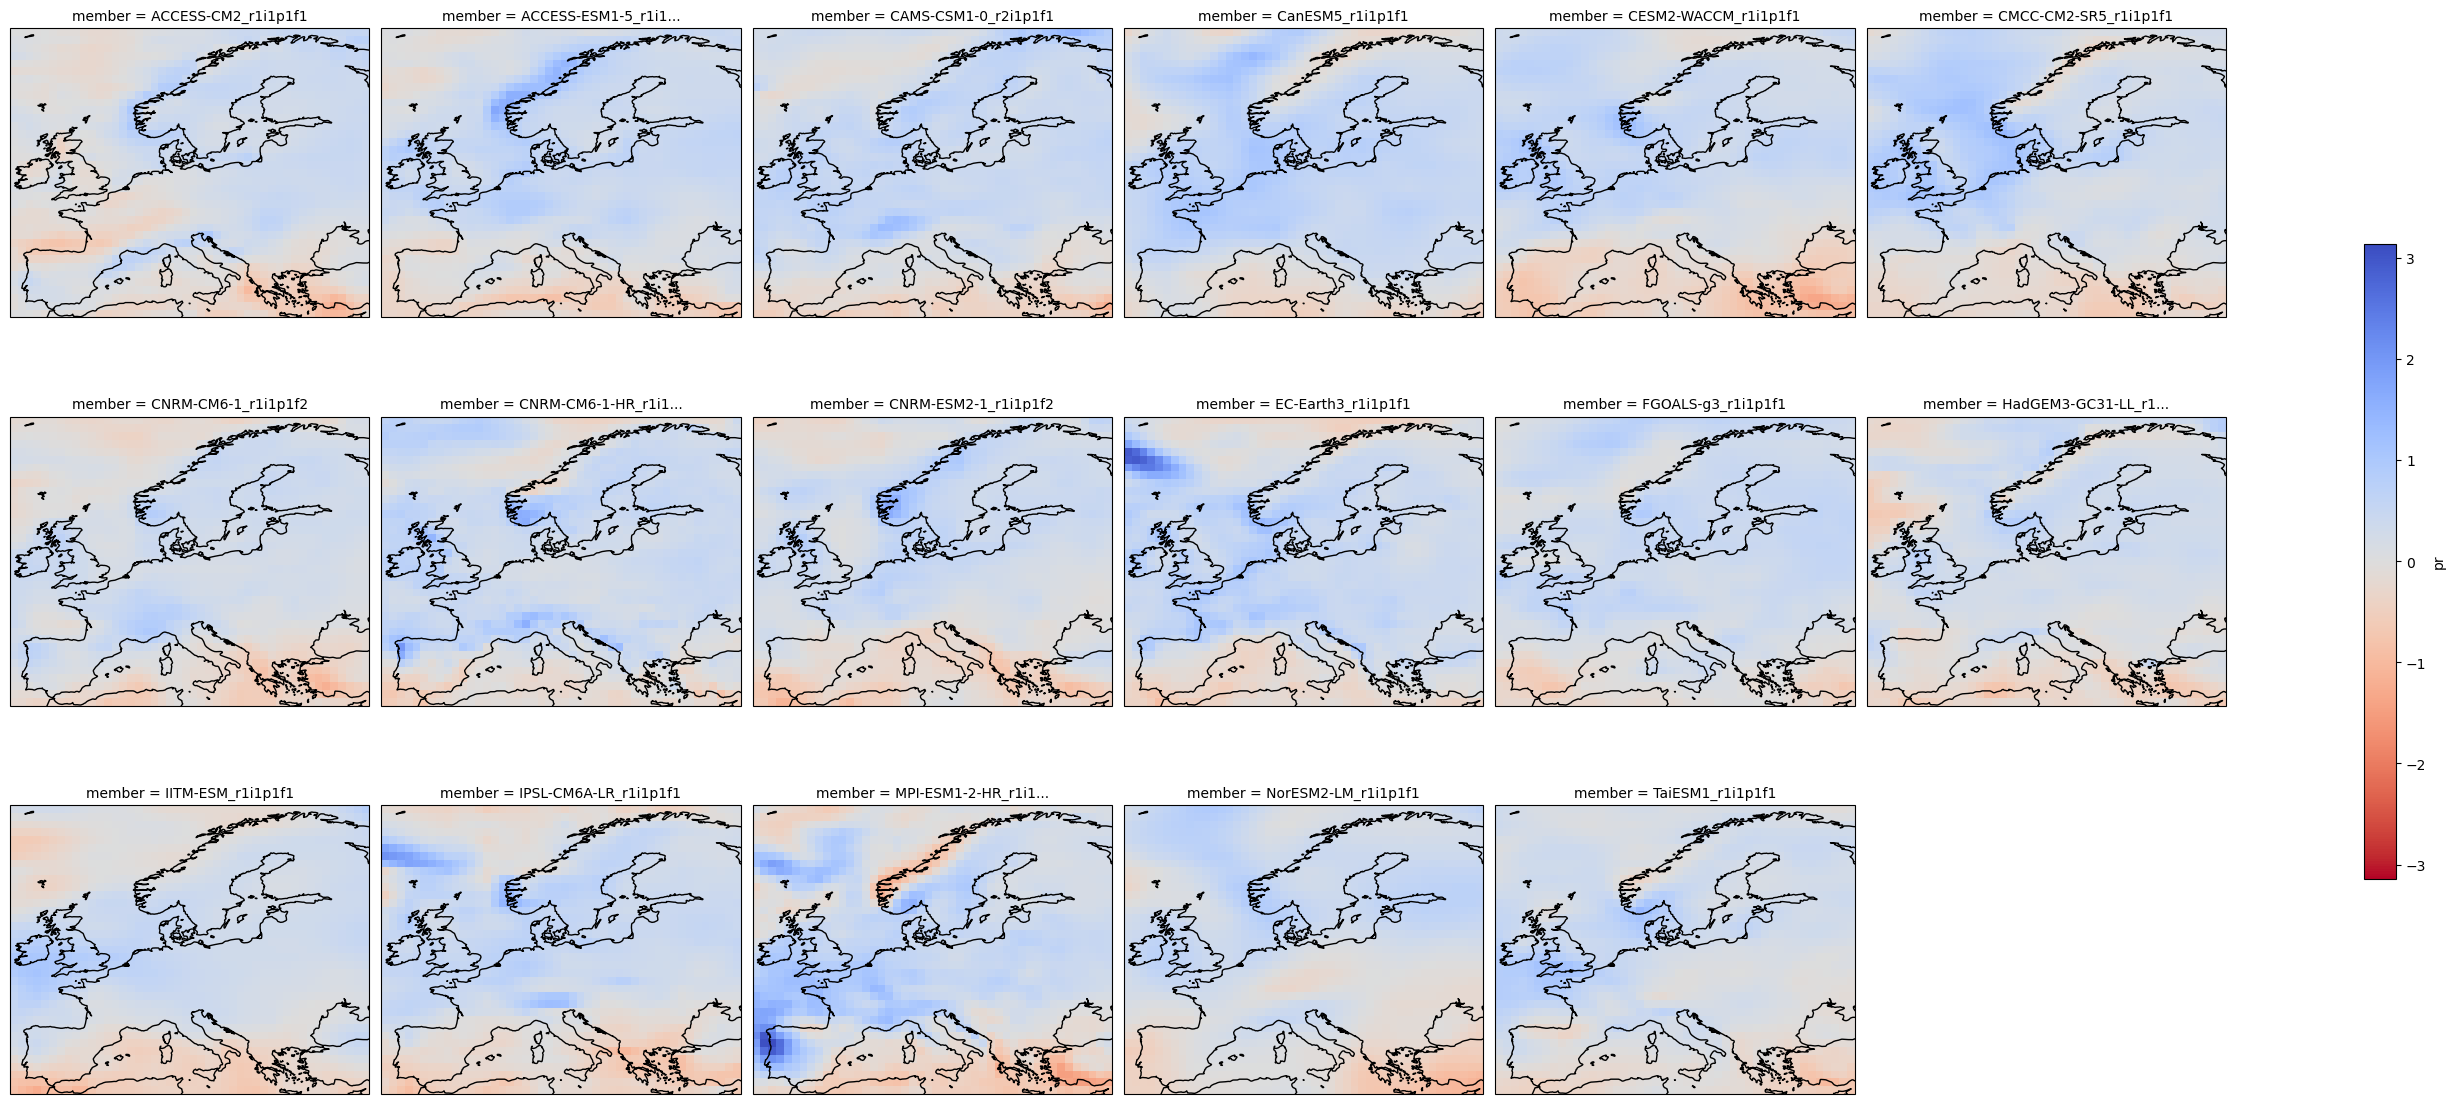

In [133]:
plot = delta.plot(
    x="lon", y="lat", col="member", col_wrap=6,
    figsize=(28,13),
    add_colorbar=True,
    cmap="coolwarm_r",
    cbar_kwargs={"shrink": .5},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((lons.start, lons.stop, lats.start, lats.stop), ccrs.PlateCarree())

In [134]:
delta_rel = (delta / cmip6_historical_gwl["pr"].mean("time")) * 100

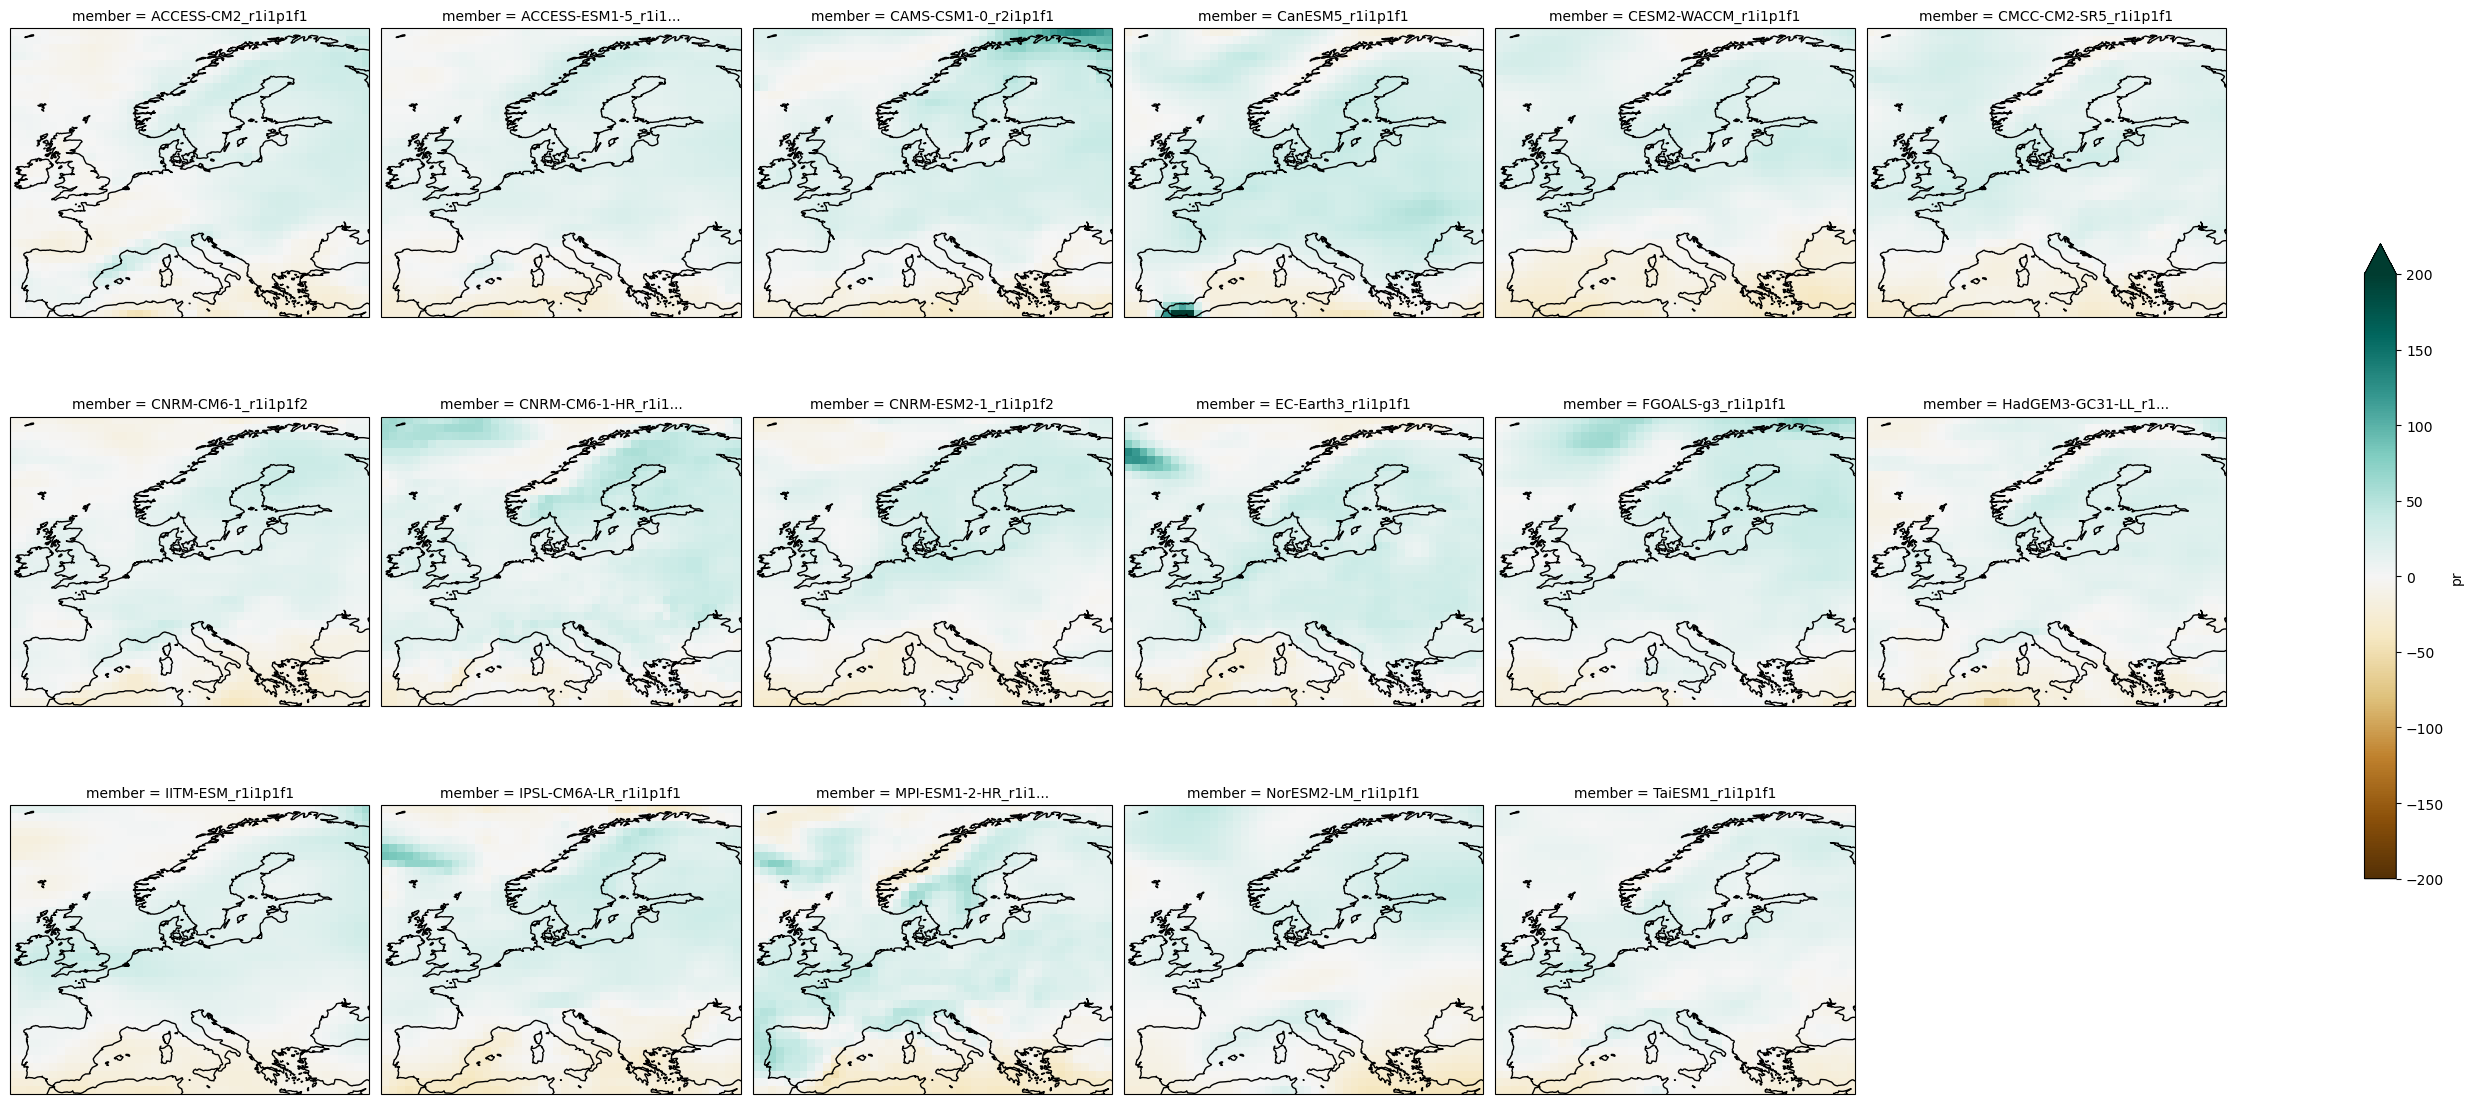

In [135]:
plot = delta_rel.plot(
    x="lon", y="lat", col="member", col_wrap=6,
    figsize=(28,13),
    vmax=200, vmin=-200,
    add_colorbar=True,
    cmap="BrBG",
    cbar_kwargs={"shrink": .5},
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

for ax in plot.axs.flatten():
    ax.coastlines()
    ax.set_extent((lons.start, lons.stop, lats.start, lats.stop), ccrs.PlateCarree())

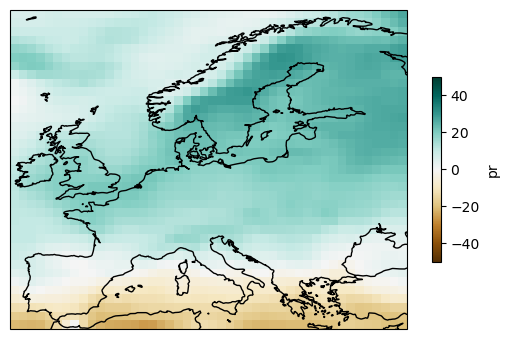

In [136]:
ens_mean = delta_rel.mean("member")

plot = ens_mean.plot(
    add_colorbar=True,
    cmap="BrBG",
    cbar_kwargs={"shrink": .5},
    vmin=-50, vmax=50,
    subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0)),
    transform=ccrs.PlateCarree())

plot.axes.coastlines()

# Pangeo

In [67]:
pangeo_catalog = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
pangeo_catalog.head()

activity_id institution_id     source_id       experiment_id member_id  \
0  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
1  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
2  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
3  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
4  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   

  table_id variable_id grid_label  \
0     Amon          ps         gn   
1     Amon        rsds         gn   
2     Amon        rlus         gn   
3     Amon        rlds         gn   
4     Amon         psl         gn   

                                              zstore  dcpp_init_year   version  
0  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
1  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
2  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
3  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
4  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706

In [113]:
locations_pangeo = []
locations_esgfva = []

for model in versions.keys():
    member = members[model]
    subset = pangeo_catalog.query(f"source_id == '{model}' & table_id == 'day' & variable_id == 'pr' & experiment_id == 'ssp585' & member_id == '{members[model]}'")
    if len(subset) > 0:
        locations_pangeo.append(subset["zstore"].iloc[0])
    else:
        print(f"Missing Pangeo {model}")

    pangeo_version = locations_pangeo[-1].split("/")[-2]
    subset = esgf_va_catalog.query(f"project == 'CMIP6' & model == '{model}' & table == 'day' & variable == 'pr' & experiment == 'ssp585' & version == '{pangeo_version}'")
    if len(subset) > 0:
        locations_esgfva.append(subset["location"].iloc[0])
    else:
        print(f"Missing ESGF-VA {model}")

In [116]:
len(locations_pangeo), len(locations_esgfva)

(19, 19)

In [117]:
locations_pangeo[0], locations_esgfva[0]

('gs://cmip6/CMIP6/ScenarioMIP/CSIRO-ARCCSS/ACCESS-CM2/ssp585/r1i1p1f1/day/pr/gn/v20210317/',
 'https://hub.ipcc.ifca.es/thredds/dodsC/esgeva/ensemble/CMIP6/ScenarioMIP/day/CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp585_day_gn_v20210317/CMIP6_ScenarioMIP_CSIRO-ARCCSS_ACCESS-CM2_ssp585_day_pr_gn_v20210317.ncml')

Check if shapes match.

In [ ]:
for esgfva_location, pangeo_location in list(zip(locations_esgfva, locations_pangeo)):
    try:
        esgfva = xarray.open_dataset(esgfva_location)
        pangeo = xarray.open_zarr(pangeo_location)
    
        print(esgfva["pr"].sel(variant_label=members[esgfva.attrs["source_id"]].encode("ascii")).shape, pangeo["pr"].shape)
    except:
        print("Error, continue...")

/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/coding/times.py:1005: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/coding/times.py:1005: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/core/indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/codi

(104459, 144, 192) (18262, 144, 192)


/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/coding/times.py:1005: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/coding/times.py:1005: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/core/indexing.py:516: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(self.get_duck_array(), dtype=dtype)
/home/zequi/miniconda3/lib/python3.10/site-packages/xarray/codi

(104459, 145, 192) (104459, 145, 192)


oc_open: server error retrieving url: code=500 message="http://esgf3.dkrz.de/thredds/dodsC/cmip6/ScenarioMIP/AWI/AWI-CM-1-1-MR/ssp585/r1i1p1f1/day/pr/gn/v20190529/pr_day_AWI-CM-1-1-MR_ssp585_r1i1p1f1_gn_20990101-20991231.nc is not a valid URL, return status=404"

Error, continue...


oc_open: server error retrieving url: code=500 message="http://esg.camscma.cn/thredds/dodsC/cmip6/CMIP6/ScenarioMIP/CAMS/CAMS-CSM1-0/ssp585/r2i1p1f1/day/pr/gn/v20191106/pr_day_CAMS-CSM1-0_ssp585_r2i1p1f1_gn_20150101-20991231.nc is not a valid URL, return status=400"

Error, continue...
(31390, 64, 128) (60590, 64, 128)


oc_open: server error retrieving url: code=500 message="http://esgf-data.ucar.edu/thredds/dodsC/esg_dataroot/CMIP6/ScenarioMIP/NCAR/CESM2-WACCM/ssp585/r1i1p1f1/day/pr/gn/v20200702/pr_day_CESM2-WACCM_ssp585_r1i1p1f1_gn_22810101-22901231.nc is not a valid URL, return status=400"

Error, continue...


oc_open: server error retrieving url: code=500 message="org.apache.http.conn.ConnectTimeoutException: Connect to esgf-node2.cmcc.it:80 [esgf-node2.cmcc.it/193.204.199.223] failed: Connect timed out"

Error, continue...
